In [1]:
# Install dependencies if not already installed
!pip install pandas numpy scikit-learn matplotlib seaborn boto3 sagemaker --quiet


In [22]:
# Import data handling libraries
import pandas as pd
import numpy as np

# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Import AWS SageMaker-related libraries
import boto3
import sagemaker
from sagemaker import get_execution_role

# Import model training libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Import libraries for saving the model
import pickle
import joblib

# Display library versions
print("Pandas version:", pd.__version__)
print("NumPy version:", np.__version__)
print("Scikit-Learn version:", joblib.__version__)


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


[02/28/25 04:53:38] INFO     Found credentials from IAM Role:                                   ]8;id=198811;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=531488;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
Pandas version: 1.5.3
NumPy version: 1.26.4
Scikit-Learn version: 1.4.2


In [3]:
# Get SageMaker execution role
role = get_execution_role()
print("SageMaker execution role:", role)


[02/28/25 04:19:48] INFO     Found credentials from IAM Role:                                   ]8;id=137682;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=68451;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

SageMaker execution role: arn:aws:iam::904233093112:role/SageMakerExecutionRole


In [1]:
!pip install --upgrade s3fs


In [2]:
import s3fs
print(s3fs.__version__)  # Ensure it's the latest version


2025.2.0


In [19]:
import pandas as pd

# Define S3 path
s3_path = "s3://marketing-campaign-680/marketing_campaign.csv"

# Load dataset
df = pd.read_csv(s3_path)
df.head()



,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


In [20]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values[missing_values > 0])


Missing Values:
 Income    24
dtype: int64


In [21]:
# fill missing values with median (for numerical columns)
df.fillna(df.median(), inplace=True)

# Verify missing values are handled
print("Missing Values after cleaning:\n", df.isnull().sum().sum())


Missing Values after cleaning:
 0


/tmp/ipykernel_25864/1459415059.py:2: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.fillna(df.median(), inplace=True)


In [16]:
# Display column data types
print(df.dtypes)


ID                       int64
Year_Birth               int64
Education               object
Marital_Status          object
Income                 float64
Kidhome                  int64
Teenhome                 int64
Dt_Customer             object
Recency                  int64
MntWines                 int64
MntFruits                int64
MntMeatProducts          int64
MntFishProducts          int64
MntSweetProducts         int64
MntGoldProds             int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
AcceptedCmp3             int64
AcceptedCmp4             int64
AcceptedCmp5             int64
AcceptedCmp1             int64
AcceptedCmp2             int64
Complain                 int64
Z_CostContact            int64
Z_Revenue                int64
Response                 int64
dtype: object


In [18]:
# Identify categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns
print("Categorical Columns:", categorical_cols)

# Convert categorical variables to numerical using one-hot encoding
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Verify encoding
df.head(20)


Categorical Columns: Index([], dtype='object')


,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,Dt_Customer_2014-06-20,Dt_Customer_2014-06-21,Dt_Customer_2014-06-22,Dt_Customer_2014-06-23,Dt_Customer_2014-06-24,Dt_Customer_2014-06-25,Dt_Customer_2014-06-26,Dt_Customer_2014-06-27,Dt_Customer_2014-06-28,Dt_Customer_2014-06-29
0,5524,1957,58138.0,0,0,58,635,88,546,172,...,0,0,0,0,0,0,0,0,0,0
1,2174,1954,46344.0,1,1,38,11,1,6,2,...,0,0,0,0,0,0,0,0,0,0
2,4141,1965,71613.0,0,0,26,426,49,127,111,...,0,0,0,0,0,0,0,0,0,0
3,6182,1984,26646.0,1,0,26,11,4,20,10,...,0,0,0,0,0,0,0,0,0,0
4,5324,1981,58293.0,1,0,94,173,43,118,46,...,0,0,0,0,0,0,0,0,0,0
5,7446,1967,62513.0,0,1,16,520,42,98,0,...,0,0,0,0,0,0,0,0,0,0
6,965,1971,55635.0,0,1,34,235,65,164,50,...,0,0,0,0,0,0,0,0,0,0
7,6177,1985,33454.0,1,0,32,76,10,56,3,...,0,0,0,0,0,0,0,0,0,0
8,4855,1974,30351.0,1,0,19,14,0,24,3,...,0,0,0,0,0,0,0,0,0,0
9,5899,1950,5648.0,1,1,68,28,0,6,1,...,0,0,0,0,0,0,0,0,0,0


[02/28/25 05:03:24] INFO     Using categorical units to plot a list of strings that are all         ]8;id=160715;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=648116;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/category.py#224\224]8;;\
                             parsable as floats or dates. If these strings should be plotted as                    
                             numbers, cast to the appropriate data type before plotting.                           

/tmp/ipykernel_25864/1585074022.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Response", data=df, palette="coolwarm")


                    INFO     Using categorical units to plot a list of strings that are all         ]8;id=683937;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=927746;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/category.py#224\224]8;;\
                             parsable as floats or dates. If these strings should be plotted as                    
                             numbers, cast to the appropriate data type before plotting.                           

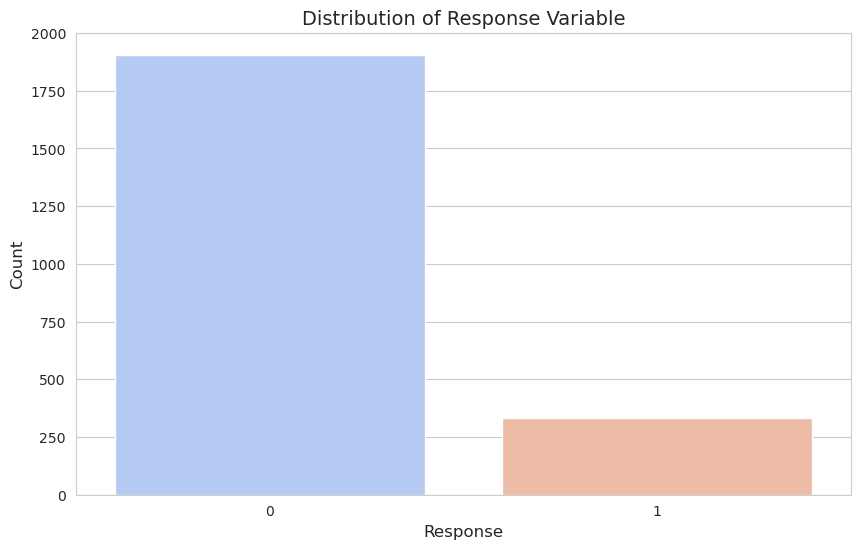

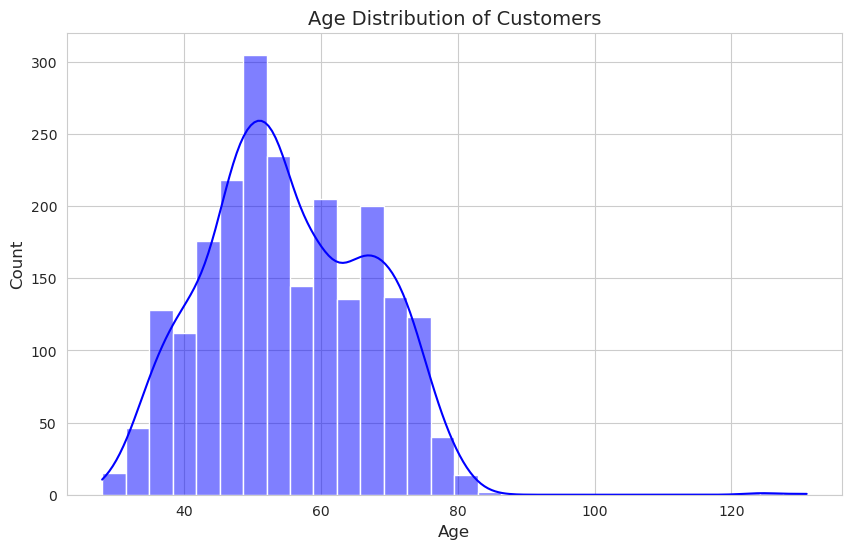

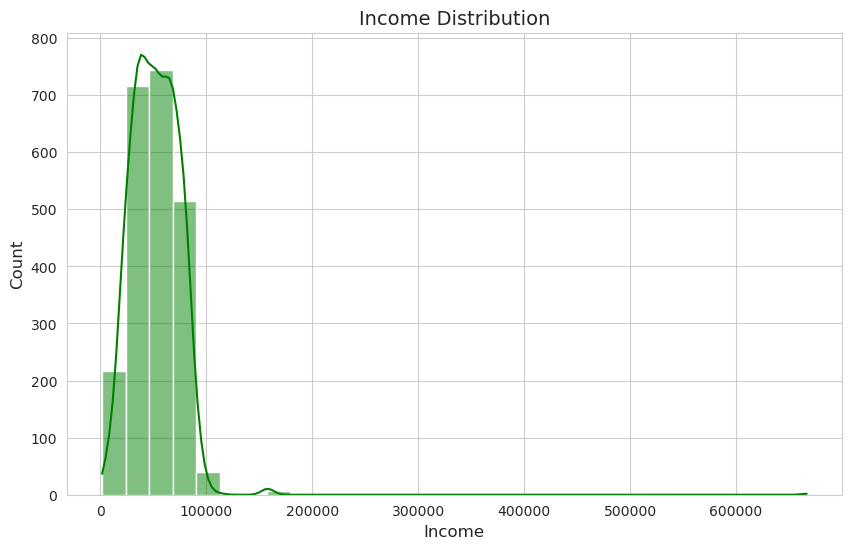

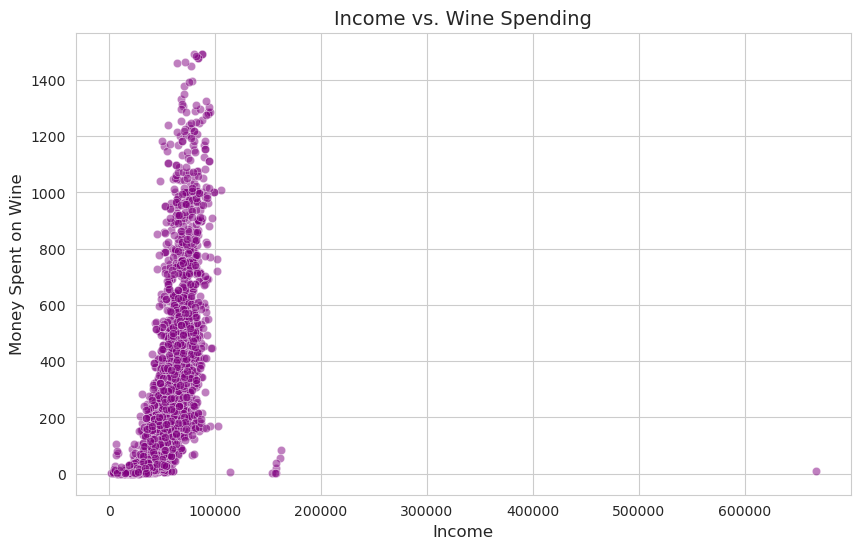

/tmp/ipykernel_25864/1585074022.py:43: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=False, cmap="coolwarm")


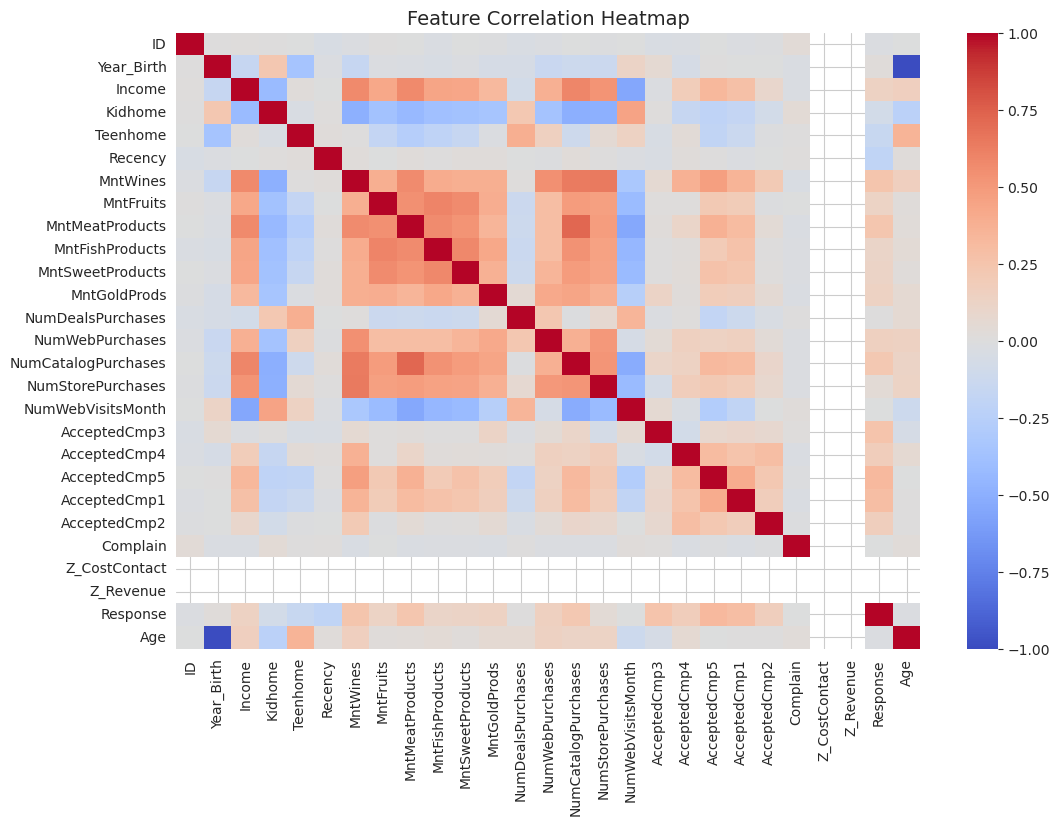

In [32]:
# Import required libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style for better aesthetics
sns.set_style("whitegrid")

# 1️ Distribution of the Target Variable (Response)
plt.figure(figsize=(10, 6))
sns.countplot(x="Response", data=df, palette="coolwarm")
plt.title("Distribution of Response Variable", fontsize=14)
plt.xlabel("Response", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

# 2️ Age Distribution of Customers (Year of Birth Converted to Age)
plt.figure(figsize=(10, 6))
df["Age"] = 2024 - df["Year_Birth"]
sns.histplot(df["Age"], bins=30, kde=True, color="blue")
plt.title("Age Distribution of Customers", fontsize=14)
plt.xlabel("Age", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

# 3️ Income Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df["Income"].dropna(), bins=30, kde=True, color="green")
plt.title("Income Distribution", fontsize=14)
plt.xlabel("Income", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

# 4️ Relationship Between Income and Spending on Wines
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df["Income"], y=df["MntWines"], alpha=0.5, color="purple")
plt.title("Income vs. Wine Spending", fontsize=14)
plt.xlabel("Income", fontsize=12)
plt.ylabel("Money Spent on Wine", fontsize=12)
plt.show()

# 5️ Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=False, cmap="coolwarm")
plt.title("Feature Correlation Heatmap", fontsize=14)
plt.show()


In [35]:
print(df.columns)


Index(['Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response',
       'Age', 'Customer_Tenure', 'Total_Spending', 'Total_Purchases',
       'Education_Basic', 'Education_Graduation', 'Education_Master',
       'Education_PhD', 'Marital_Status_Alone', 'Marital_Status_Divorced',
       'Marital_Status_Married', 'Marital_Status_Single',
       'Marital_Status_Together', 'Marital_Status_Widow',
       'Marital_Status_YOLO'],
      dtype='object')


In [37]:
# Step 4: Feature Selection and Model Training

# 1️ Define Features and Target Variable
X = df.drop(columns=["Response"])  # Features
y = df["Response"]  # Target

# 2️ Split Data into Train, Validation, and Test Sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 3️ Train a Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 4️ Model Evaluation on Validation Set
y_val_pred = model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print("Classification Report:\n", classification_report(y_val, y_val_pred))

# 5️ Save the Model for Deployment
import joblib
joblib.dump(model, "marketing_campaign_model.pkl")


Validation Accuracy: 0.8631
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.92       289
           1       0.53      0.21      0.30        47

    accuracy                           0.86       336
   macro avg       0.70      0.59      0.61       336
weighted avg       0.83      0.86      0.84       336



['marketing_campaign_model.pkl']

In [39]:
import boto3

# Define S3 bucket and file path
s3_bucket = "marketing-campaign-680"  # Replace with your actual S3 bucket name
s3_key = "models/marketing_campaign_model.pkl"  # Define the model path in S3

# Upload model to S3
s3_client = boto3.client("s3")
s3_client.upload_file("marketing_campaign_model.pkl", s3_bucket, s3_key)

# Print confirmation
s3_model_path = f"s3://{s3_bucket}/{s3_key}"
print(f"Model successfully uploaded to: {s3_model_path}")


Model successfully uploaded to: s3://marketing-campaign-680/models/marketing_campaign_model.pkl


In [65]:
%%writefile app.py
from flask import Flask, request, jsonify, render_template
from flask_cors import CORS
import joblib
import numpy as np
import os
import logging

# Initialize Flask app
app = Flask(__name__, template_folder="templates")
CORS(app)  # Enable CORS for front-end requests

# Configure logging
logging.basicConfig(level=logging.INFO)

# Define model path
MODEL_PATH = "marketing_campaign_model.pkl"

# Check if model file exists
if not os.path.exists(MODEL_PATH):
    logging.error(f"Model file not found at {MODEL_PATH}")
    raise FileNotFoundError(f"Model file not found at {MODEL_PATH}")

# Load the trained model
try:
    model = joblib.load(MODEL_PATH)
    expected_features = model.n_features_in_
    logging.info(f"Model loaded successfully. Expecting {expected_features} features.")
except Exception as e:
    logging.error(f"Error loading model: {e}")
    raise e

@app.route("/", methods=["GET"])
def home():
    return render_template("index.html")  # Serve the front-end HTML page

@app.route("/predict", methods=["POST"])
def predict():
    try:
        # Get input JSON data
        data = request.get_json()

        # Validate JSON structure
        if "features" not in data:
            logging.warning("Received request with missing 'features' key.")
            return jsonify({"error": "Missing 'features' key in request"}), 400

        features = data["features"]

        # Ensure input is a list of numbers
        if not isinstance(features, list) or not all(isinstance(x, (int, float)) for x in features):
            logging.warning("Invalid input: Features must be a list of numbers.")
            return jsonify({"error": "Invalid input: 'features' must be a list of numbers"}), 400

        # Convert input list to NumPy array
        input_data = np.array(features).reshape(1, -1)

        # Validate input shape
        if input_data.shape[1] != expected_features:
            logging.warning(f"Feature length mismatch: Expected {expected_features}, got {input_data.shape[1]}")
            return jsonify({"error": f"Expected {expected_features} features, got {input_data.shape[1]}"}), 400

        # Make prediction
        prediction = model.predict(input_data)[0]
        logging.info(f"Prediction made successfully: {prediction}")

        # Return response
        return jsonify({"prediction": int(prediction)})

    except Exception as e:
        logging.error(f"Error during prediction: {str(e)}")
        return jsonify({"error": "Internal server error"}), 500

if __name__ == '__main__':
    port = int(os.environ.get("PORT", 8080))  # Use Heroku's port or default to 8080
    logging.info(f"Starting Flask server on port {port}...")
    app.run(debug=True, host="0.0.0.0", port=port)


Overwriting app.py


In [70]:
%%writefile templates/index.html
<!DOCTYPE html>
<html lang="en">
<head>
  <meta charset="UTF-8">
  <meta name="viewport" content="width=device-width, initial-scale=1.0">
  <title>Marketing Campaign Prediction</title>
  
  <!-- Bootstrap CDN -->
  <link rel="stylesheet" 
        href="https://cdn.jsdelivr.net/npm/bootstrap@5.3.0/dist/css/bootstrap.min.css">

  <style>
    body {
      background-color: #f8f9fa;
    }
    .container {
      max-width: 600px;
      background: white;
      margin: auto;
      margin-top: 50px;
      padding: 20px;
      border-radius: 10px;
      box-shadow: 0px 4px 10px rgba(0, 0, 0, 0.1);
    }
    .btn-primary {
      width: 100%;
    }
    .result {
      font-size: 18px;
      font-weight: bold;
      margin-top: 15px;
      text-align: center;
    }
    .loading {
      display: none;
      text-align: center;
      font-size: 16px;
      color: #007bff;
    }
  </style>
</head>
<body>

  <div class="container">
    <h3 class="text-center">Marketing Campaign Prediction</h3>
    
    <form id="predictionForm">
      <!-- 15 input fields with default values -->
      <label for="income" class="form-label">Income ($)</label>
      <input type="number" class="form-control" id="income" value="50000" required>

      <label for="kidhome" class="form-label">Kids at Home</label>
      <input type="number" class="form-control" id="kidhome" value="0" required>

      <label for="teenhome" class="form-label">Teens at Home</label>
      <input type="number" class="form-control" id="teenhome" value="1" required>

      <label for="recency" class="form-label">Recency (days)</label>
      <input type="number" class="form-control" id="recency" value="30" required>

      <label for="mntwines" class="form-label">Amount Spent on Wine ($)</label>
      <input type="number" class="form-control" id="mntwines" value="200" required>

      <label for="mntfruits" class="form-label">Amount Spent on Fruits ($)</label>
      <input type="number" class="form-control" id="mntfruits" value="50" required>

      <label for="mntmeat" class="form-label">Amount Spent on Meat ($)</label>
      <input type="number" class="form-control" id="mntmeat" value="300" required>

      <label for="mntfish" class="form-label">Amount Spent on Fish ($)</label>
      <input type="number" class="form-control" id="mntfish" value="100" required>

      <label for="mntsweets" class="form-label">Amount Spent on Sweets ($)</label>
      <input type="number" class="form-control" id="mntsweets" value="50" required>

      <label for="mntgold" class="form-label">Amount Spent on Gold ($)</label>
      <input type="number" class="form-control" id="mntgold" value="40" required>

      <label for="numdeals" class="form-label">Number of Deals Purchased</label>
      <input type="number" class="form-control" id="numdeals" value="2" required>

      <label for="numweb" class="form-label">Number of Web Purchases</label>
      <input type="number" class="form-control" id="numweb" value="5" required>

      <label for="numcatalog" class="form-label">Number of Catalog Purchases</label>
      <input type="number" class="form-control" id="numcatalog" value="3" required>

      <label for="numstore" class="form-label">Number of Store Purchases</label>
      <input type="number" class="form-control" id="numstore" value="7" required>

      <label for="numwebvisits" class="form-label">Number of Web Visits</label>
      <input type="number" class="form-control" id="numwebvisits" value="10" required>

      <!-- The remaining 23 feature values will be padded automatically with 0 -->
      <button type="button" class="btn btn-primary mt-3" onclick="getPrediction()">Predict</button>
    </form>

    <p class="loading" id="loading">Processing...</p>
    <p class="result" id="result"></p>
  </div>

  <!-- JavaScript Code -->
  <script>
    async function getPrediction() {
      document.getElementById("loading").style.display = "block";
      document.getElementById("result").innerText = "";
      
      // Gather 15 features from the input fields
      let features = [
        parseFloat(document.getElementById("income").value),
        parseInt(document.getElementById("kidhome").value),
        parseInt(document.getElementById("teenhome").value),
        parseInt(document.getElementById("recency").value),
        parseFloat(document.getElementById("mntwines").value),
        parseFloat(document.getElementById("mntfruits").value),
        parseFloat(document.getElementById("mntmeat").value),
        parseFloat(document.getElementById("mntfish").value),
        parseFloat(document.getElementById("mntsweets").value),
        parseFloat(document.getElementById("mntgold").value),
        parseInt(document.getElementById("numdeals").value),
        parseInt(document.getElementById("numweb").value),
        parseInt(document.getElementById("numcatalog").value),
        parseInt(document.getElementById("numstore").value),
        parseInt(document.getElementById("numwebvisits").value)
      ];
      
      // Pad with 0's until we have 38 features
      while (features.length < 38) {
        features.push(0);
      }
      
      let inputData = { features: features };
      
      // Use your production URL 
      let apiUrl = "https://marketing-campaign-api.herokuapp.com/predict";
      // For local testing, you can use:
      // let apiUrl = "http://localhost:8080/predict";
      
      try {
        let response = await fetch(apiUrl, {
          method: "POST",
          mode: "cors",  // explicitly allow cross-origin requests
          headers: { "Content-Type": "application/json" },
          body: JSON.stringify(inputData)
        });
        
        if (!response.ok) {
          let errorText = await response.text();
          document.getElementById("loading").style.display = "none";
          document.getElementById("result").innerText = "Error " + response.status + ": " + errorText;
          document.getElementById("result").style.color = "red";
          console.error("Server responded with error:", response.status, errorText);
          return;
        }
        
        let result = await response.json();
        document.getElementById("loading").style.display = "none";
        
        if ("prediction" in result) {
          let predictionText = result.prediction === 1 
            ? "Positive Response (Likely to Accept Offer)" 
            : "Negative Response (Unlikely to Accept)";
          document.getElementById("result").innerText = predictionText;
          document.getElementById("result").style.color = result.prediction === 1 ? "green" : "red";
        } else {
          document.getElementById("result").innerText = "Error: " + result.error;
          document.getElementById("result").style.color = "red";
        }
      } catch (error) {
        document.getElementById("loading").style.display = "none";
        document.getElementById("result").innerText = "Server error. Try again later. " + error;
        document.getElementById("result").style.color = "red";
        console.error("Fetch error:", error);
      }
    }
  </script>

</body>
</html>


Overwriting templates/index.html


In [52]:
import requests

url = "http://localhost:8080/predict"
data = {
    "features": [50000, 0, 1, 30, 200, 50, 300, 100, 50, 40, 2, 5, 3, 7, 10, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 3, 2, 4, 5, 0, 1, 0, 1, 1]
}

response = requests.post(url, json=data)
print(response.json())


{'prediction': 1}


In [49]:
import joblib

# Load the trained model
model = joblib.load("marketing_campaign_model.pkl")

# Print the number of expected features
print("Model expects", model.n_features_in_, "features")



Model expects 38 features


In [53]:
%%writefile Dockerfile
# Use official Python image as base
FROM python:3.9

# Set working directory inside the container
WORKDIR /app

# Copy requirements file and install dependencies
COPY requirements.txt requirements.txt
RUN pip install --no-cache-dir -r requirements.txt

# Copy application files
COPY . .

# Expose Flask API on port 8080
EXPOSE 8080

# Command to run the Flask app
CMD ["python", "app.py"]


Writing Dockerfile


In [58]:
%%writefile requirements.txt
flask
flask_cors
gunicorn
joblib
numpy
scikit-learn


Overwriting requirements.txt


In [55]:
%%writefile .dockerignore
lost+found
__pycache__
.DS_Store


Overwriting .dockerignore


In [56]:
%%writefile Procfile
web: gunicorn -w 4 -b 0.0.0.0:$PORT app:app


Writing Procfile


In [57]:
%%writefile .github/workflows/deploy.yml
name: Deploy Flask App to Heroku

on:
  push:
    branches:
      - main

jobs:
  deploy:
    runs-on: ubuntu-latest

    steps:
    - name: Checkout repository
      uses: actions/checkout@v3

    - name: Set up Python
      uses: actions/setup-python@v3
      with:
        python-version: 3.9

    - name: Install dependencies
      run: |
        pip install -r requirements.txt

    - name: Login to Heroku
      run: echo "${{ secrets.HEROKU_API_KEY }}" | docker login --username=_ --password-stdin registry.heroku.com

    - name: Build and push Docker image
      run: |
        heroku container:login
        heroku container:push web --app ${{ secrets.HEROKU_APP_NAME }}
        heroku container:release web --app ${{ secrets.HEROKU_APP_NAME }}


Writing .github/workflows/deploy.yml


In [59]:
%%writefile .gitignore
lost+found/
__pycache__/
*.pyc
*.pyo
*.pyd
.env
venv/
.idea/
.vscode/
.DS_Store


Writing .gitignore


In [62]:
import requests

# Set the API endpoint URL
api_url = "http://localhost:8080/predict"  # For local testing
# If deployed on Heroku, use something like:
# api_url = "https://marketing-campaign-api.herokuapp.com/predict"

# Create your input data with the expected number of features
data = {
    "features": [50000, 0, 1, 30, 200, 50, 300, 100, 50, 40, 2, 5, 3, 7, 10, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 3, 2, 4, 5, 0, 1, 0, 1, 1]
}

# Send the POST request to the API
response = requests.post(api_url, json=data)

# Check the response
if response.ok:
    print("Prediction response:", response.json())
else:
    print("Error:", response.status_code, response.text)


Prediction response: {'prediction': 1}
